In [1]:
%matplotlib inline
import os, sys, glob
import numpy as np
from matplotlib import pyplot as plt
#
sys.path.append('/home/fpoitevi/notebooks/cryo_home/slaclab/cryoEM-notebooks/src/')
import simutils
import cryoemio
import dmutils

The history saving thread hit an unexpected error (OperationalError('disk I/O error',)).History will not be written to the database.


In [2]:
SIMULATIONDIR='/gpfs/slac/cryo/fs1/g/ML/cryoEM-notebooks/data/Simulation/synthetic_datasets/'
DATADIR = SIMULATIONDIR+'randomrot1D_multiPDB/'
#DATADIR = '/Users/mtrigo/Documents/cryoEM/randomrot1D/'

In [3]:
## 
binning = 4
## define the parameters for the DM
b = 150
sigma2 = 6e6
alpha = 1

In [51]:
## load data and bin images
filelist = glob.glob(DATADIR+"3j9z*no_noise.h5")
particles   = []
defocus     = []
coordinates = []
for file in filelist:
    dic = cryoemio.load_dict_from_hdf5(file)
    particles.append(dic['data'][:,::binning,::binning])
    defocus.append([ dic['optics']['defocus_nominal'] for i in range(dic['data'].shape[0]) ]) #*dic['data'].shape[0])
    coordinates.append(dic['coordinates'])
particles   = np.array(particles)
particles   = particles.reshape( (particles.shape[0]*particles.shape[1],particles.shape[2],particles.shape[3]) )
defocus     = np.array(defocus)
defocus     = defocus.reshape( (defocus.shape[0]*defocus.shape[1]) )
coordinates = np.array(coordinates)
coordinates = coordinates.reshape( (coordinates.shape[0]*coordinates.shape[1],coordinates.shape[2]) )

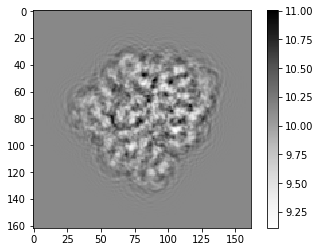

In [52]:
plt.imshow(particles[0,...], cmap='Greys')
plt.colorbar()

In [53]:
W = dmutils.dm_affinity_matrix(particles.reshape(particles.shape[0],particles.shape[1]*particles.shape[2]), b, sigma2, alpha)

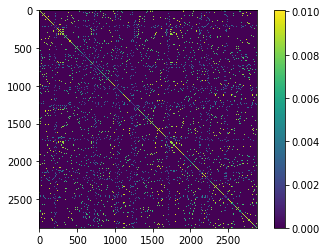

In [54]:
plt.imshow(W)
plt.colorbar()

In [55]:
from scipy.linalg import svd
U,s,V = svd(W,full_matrices=False)
U = U/U[:,0]

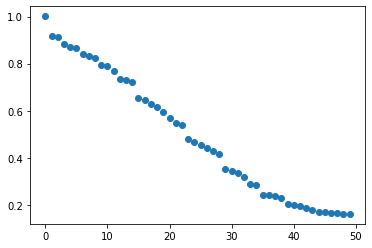

In [56]:
# pyl.plot(np.log(s),'o')
plt.plot(s[0:50],'o')

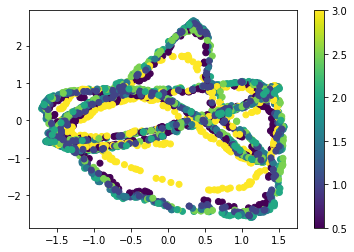

In [62]:
ii1=2
ii2=3
#plt.scatter(U[:,ii1], U[:,ii2], c=coordinates[:,3])
plt.scatter(U[:,ii1], U[:,ii2], c=defocus)
plt.colorbar()